In [2]:
import tensorflow as tf

tf.__version__

'1.13.1'

In [1]:
# Check available GPU devices
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

# Print available GPUs
available_gpus = get_available_gpus()
if available_gpus:
    print("Available GPU(s):", available_gpus)
else:
    print("No GPUs found.")

Available GPU(s): ['/device:GPU:0']


## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import scipy.special as ssp
import sys
import scipy.io as sio
sys.path.append("../code/")
from pi_vae import *
from util import *
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import KFold

## import plot packages
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker
import seaborn

%load_ext autoreload
%autoreload 2
%matplotlib inline

/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/tensorflow/pyth

## Load Data

In [2]:
data_dir = "../data"
ecephys_session_id = 771160300
brain_region = 'CA1'

directory_path = os.path.join(data_dir, f'session_{ecephys_session_id}')

# Read spike count data pivoted by neurons and time bins
spike_data_file = f'{brain_region}_spike_count_{ecephys_session_id}_pivot_p4.csv'
spike_file_path = os.path.join(directory_path, spike_data_file)
if not os.path.exists(spike_file_path):
    raise FileNotFoundError(f"File {spike_file_path} does not exist")
spike_count_pivot = pd.read_csv(spike_file_path)

# Read behavior data
behavior_data_file = f'NaturalMovie_Behavior_{ecephys_session_id}_normalized_p4.csv'
behavior_file_path = os.path.join(directory_path, behavior_data_file)
if not os.path.exists(behavior_file_path):
    raise FileNotFoundError(f"File {behavior_file_path} does not exist")
behavior_data_df = pd.read_csv(behavior_file_path)


In [4]:
spike_count_pivot.shape

(54000, 82)

In [5]:
spike_count_pivot.shape

(54000, 82)

## Prepare Data

In [3]:
from data_processing import *

selected_behavior_vars = ['position']

x_all, u_all = transform_data(spike_count_pivot, behavior_data_df, selected_behavior_vars)

### Dry run

In [4]:
# Define model?
LATENT_DIM = 10
MODEL = "PiVAE"

np.random.seed(666);
vae = vae_mdl(dim_x=x_all[0].shape[-1], 
                   dim_z=LATENT_DIM,
                   dim_u=u_all[0].shape[-1], 
                   gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4)

Instructions for updating:
Colocations handled automatically by placer.
Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 249)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  39420       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)         

/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output encoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to encoder.
  'be expecting any data to be passed to {0}.'.format(name))
/ext3/miniconda3/envs/demo/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [5]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=666)
fold = 0
train, test=[], []
for train_index, test_index in kf.split(x_all):
    train, test = train_index, test_index
    break

train, test

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59]),
 array([ 8, 21, 23, 25, 32, 34]))

In [6]:
x_train, x_valid = x_all[train], x_all[test]
u_train, u_valid = u_all[train], u_all[test]

In [48]:
model_chk_path = f'../results/F_rat_{brain_region}_{LATENT_DIM}d_666_{MODEL}_{selected_behavior_vars[0]}.h5' ##999, 777
mcp = ModelCheckpoint(model_chk_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
s_n = vae.fit_generator(custom_data_generator(x_train, u_train),
              steps_per_epoch=len(x_train), epochs=600, 
              verbose=1,
              validation_data = custom_data_generator(x_valid, u_valid),
              validation_steps = len(x_valid), callbacks=[mcp]);

Instructions for updating:
Use tf.cast instead.


KeyboardInterrupt: 

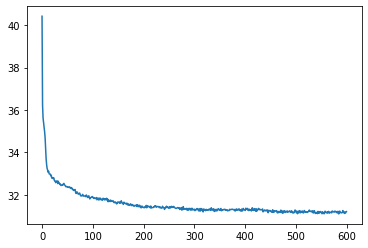

In [11]:
plt.plot(s_n.history['val_loss'][:]) # 10D

In [7]:
# model_chk_path = '../results/F_rat_10d_666_VAE.h5'
model_chk_path = f'../results/F_rat_{brain_region}_{LATENT_DIM}d_666_{MODEL}_{selected_behavior_vars[0]}.h5' ##999, 777
vae.load_weights(model_chk_path);

In [14]:

def plot_multi_latent_trajectory_pupil_vt(behavior_df, outputs, latent_indicies, workflow_name, num_stims=15, show_traj=True, save_plot=False, save_dir=None, show_plot=True, variances=None):
    """
    Plot latent trajectories from several trials on a single plot.

    Args:
    - behavior_df (pandas.DataFrame): DataFrame containing behavior data including 'frame' and 'pupil_size'.
    - outputs (numpy.ndarray): Latent data.
    - latent_indicies (numpy.ndarray): User provided latent indices.
    - workflow_name (str): Name of the workflow.
    - num_stims (int): Number of random chosen trials to plot.
    - save_plot (bool, optional): Whether to save the plot. Default is False.
    - save_dir (str, optional): Directory to save the plot. Required if save_plot is True.
    - show_plot (bool, optional): Whether to show the plot. Default is True.
    - variances (list, optional): List of variances for each latent dimension.

    Returns:
    - plots scatter where pupil size has color scale Greys in range [0,1]
    - plots trajectories of points for each trial plotted. trajectory labeled by frame with color scale Plasma in range [0s, 30s]
    """
    # Set plot font size
    fsz = 12
    # plt.rcParams.update({'font.size': fsz})
    
    # Extract pupil size data and normalize
    pupil_sizes = behavior_df['pupil_size']
    pupil_sizes_normalized = (pupil_sizes - pupil_sizes.min()) / (pupil_sizes.max() - pupil_sizes.min())
    
    # Assuming 'outputs' is your data
    latent_1_idx, latent_2_idx = latent_indicies
    print(f'Latent 1 idx: {latent_1_idx}')
    print(f'Latent 2 idx: {latent_2_idx}')
    
    # Create a new figure and axis
    fig, ax = plt.subplots()

    scatter_cmap = 'plasma'
    # Iterate over num_stims random stim_numbers
    stim_number_pool = np.random.choice(range(60), num_stims, replace=False)
    for stim_number in stim_number_pool:
        # Extract latent data for current stimulus
        latent_data_frequency = 5
        
        start_idx = 900 * stim_number
        end_idx = 900 * (stim_number + 1)
        data_slice = slice(start_idx, end_idx, latent_data_frequency)
        
        latent_1_data = outputs[0][data_slice, latent_1_idx]
        latent_2_data = outputs[0][data_slice, latent_2_idx]
        # pupil_data = pupil_sizes_normalized[data_slice]
        pupil_data = behavior_df['frame'][data_slice] # <--- Change!
        
        # Filter data based on quantiles
        lower_bound = np.quantile(latent_1_data, 0.1)
        upper_bound = np.quantile(latent_1_data, 0.9)
        filter_mask = (latent_1_data >= lower_bound) & (latent_1_data <= upper_bound)
    
        # Apply filter to both latent data and pupil sizes
        # latent_1_data_filtered = latent_1_data[filter_mask]
        # latent_2_data_filtered = latent_2_data[filter_mask]
        # pupil_data_filtered = pupil_data[filter_mask]
        latent_1_data_filtered = latent_1_data
        latent_2_data_filtered = latent_2_data
        pupil_data_filtered = pupil_data
    
        # Define point sizes based on filtered pupil size with exponential increase for higher values
        max_point_size = 100
        min_point_size = 10
        point_sizes = min_point_size + (max_point_size - min_point_size) * pupil_data_filtered
    
        # Plot the scatter plot with varying point size and hue based on pupil size
        ax.scatter(latent_1_data_filtered, latent_2_data_filtered, s=point_sizes, c=pupil_data_filtered, cmap=scatter_cmap, alpha=0.7)
        
        # Plot trajectory line with gradient color
        if show_traj:
            sample_frequency = 50
            x = outputs[0][:, latent_1_idx][900*stim_number:900*(stim_number+1)][::sample_frequency]  # Every 5th data point
            y = outputs[0][:, latent_2_idx][900*stim_number:900*(stim_number+1)][::sample_frequency]  # Every 5th data point
            time_indices = np.arange(len(x)) / len(x)  # Normalize time indices to [0, 1]
            colors = plt.cm.plasma(time_indices)  # Use colormap to create the gradient
            for j in range(len(x) - 1):  # Iterate over points to draw line segments with varying colors
                ax.plot(x[j:j+2], y[j:j+2], color=colors[j], linestyle='-', linewidth=1, alpha=0.5)

    # Set labels
    # var_1 = "{:.3f}".format(variances[latent_1_idx]) if variances is not None else ''
    # var_2 = "{:.3f}".format(variances[latent_2_idx]) if variances is not None else ''
    # ax.set_xlabel(f'Latent {latent_1_idx} (var={var_1})', fontsize=fsz)
    # ax.set_ylabel(f'Latent {latent_2_idx} (var={var_2})', fontsize=fsz)
    ax.set_xlabel(f'Latent {latent_1_idx}', fontsize=fsz)
    ax.set_ylabel(f'Latent {latent_2_idx}', fontsize=fsz)

    # Title
    if num_stims == 1:
        title = f"{workflow_name} - Trial #{stim_number_pool[0]}"
        title = "VAE-10D VISp : u=Frame"
        ax.set_title(title, fontsize=fsz)
    else:
        title = "PiVAE-10D CA1 : u= Position"
        ax.set_title(title, fontsize=fsz)

    if show_traj:
        # Add color bar for trajectory time
        cbar_trajectory = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=ax, orientation='vertical', shrink=0.7, pad=0.05, alpha=0.5)
        cbar_trajectory.set_label('Frame', fontsize=10, labelpad=0.1)
                
        # Customize color bar ticks and labels
        cbar_trajectory.set_ticks([0, 1])
        cbar_trajectory.set_ticklabels([f'0', f'900'])
        cbar_trajectory.ax.tick_params(labelsize=fsz)

    # Add color bar for pupil size
    cbar = plt.colorbar(ax.scatter([], [], c=[], cmap=scatter_cmap), ax=ax, orientation='vertical', shrink=0.7, pad=0.05)
    # cbar.set_label('Pupil Size', fontsize=10, labelpad=5)
    cbar.set_label('Frame', fontsize=10, labelpad=5)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels([f'0s', f'30s'])
            
    # Customize color bar ticks and labels
    cbar.ax.tick_params(labelsize=fsz)

    # Save or show the plot
    if save_plot:
        if save_dir:
            plt.savefig(f"{save_dir}/{workflow_name}.png")
        else:
            raise ValueError("Save directory not specified.")
    if show_plot:
        plt.show()

    plt.clf()

In [9]:
outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));
# post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
print(outputs[0].var(axis=0))  ## variance of each latent dimension

[0.02641537 0.63405323 0.15125631 3.5137002  0.5306028  1.9093169
 0.03047677 0.0316023  3.2321646  1.1051494 ]


In [10]:
z_pred_all = [];
for ii in range(len(x_all)):
    z_pred_all.append(vae.predict([x_all[ii], u_all[ii]])[0][:,:]);
z_pred_all = np.array(z_pred_all);

In [11]:
variances = outputs[0].var(axis=0)
# Sort the columns by variance in descending order and get the indices
sorted_indices = np.argsort(variances)[::-1]

# Create a new object containing the columns of outputs[0] sorted by variance
sorted_outputs = outputs[0][:, sorted_indices]
print(variances,'\n')
print(sorted_outputs.var(axis=0),'\n',sorted_indices)

u_values = behavior_data_df['frame'].unique()

[0.02641537 0.63405323 0.15125631 3.5137002  0.5306028  1.9093169
 0.03047677 0.0316023  3.2321646  1.1051494 ] 

[3.513708   3.2321594  1.9093285  1.1051573  0.63405716 0.5306032
 0.15125836 0.03160229 0.03047702 0.02641534] 
 [3 8 5 9 1 4 2 7 6 0]


In [12]:
t = [8,9,4,6,2,5, 1]

[4 2 7 6 0]
Latent 1 idx: 4
Latent 2 idx: 2


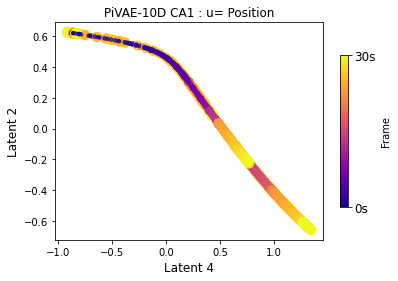

Latent 1 idx: 4
Latent 2 idx: 7


<Figure size 432x288 with 0 Axes>

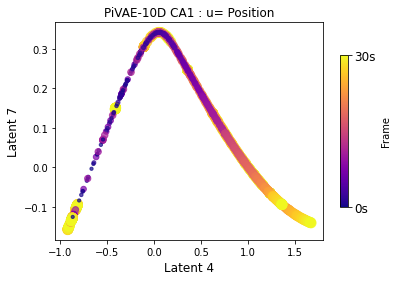

Latent 1 idx: 4
Latent 2 idx: 6


<Figure size 432x288 with 0 Axes>

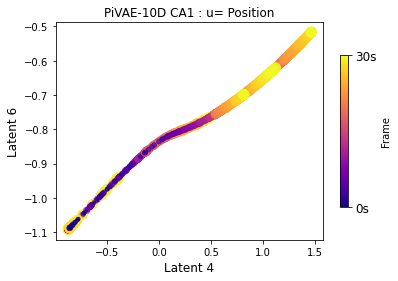

Latent 1 idx: 4
Latent 2 idx: 0


<Figure size 432x288 with 0 Axes>

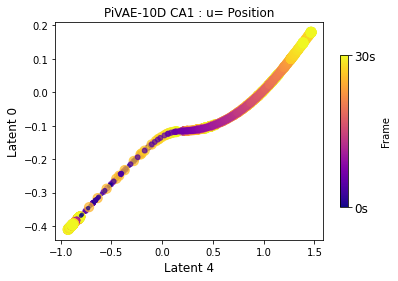

Latent 1 idx: 2
Latent 2 idx: 7


<Figure size 432x288 with 0 Axes>

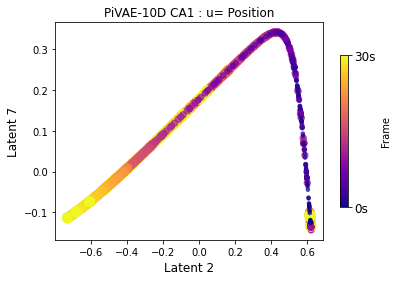

Latent 1 idx: 2
Latent 2 idx: 6


<Figure size 432x288 with 0 Axes>

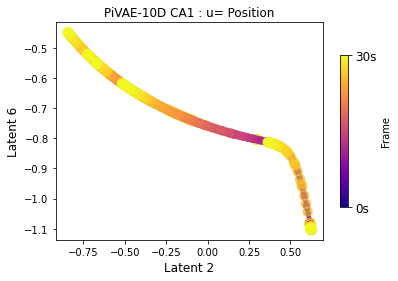

Latent 1 idx: 2
Latent 2 idx: 0


<Figure size 432x288 with 0 Axes>

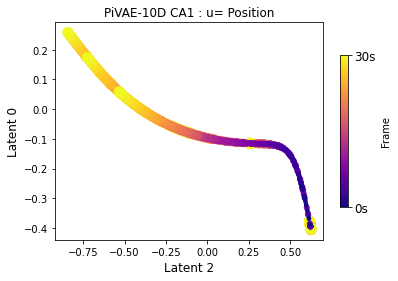

Latent 1 idx: 7
Latent 2 idx: 6


<Figure size 432x288 with 0 Axes>

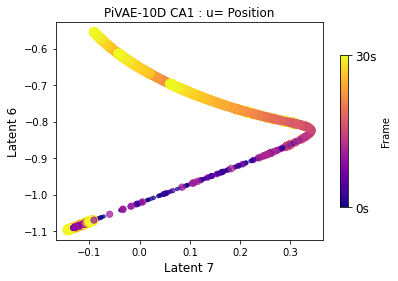

Latent 1 idx: 7
Latent 2 idx: 0


<Figure size 432x288 with 0 Axes>

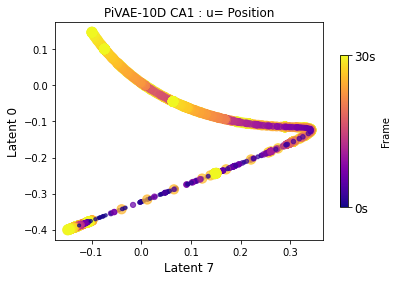

Latent 1 idx: 6
Latent 2 idx: 0


<Figure size 432x288 with 0 Axes>

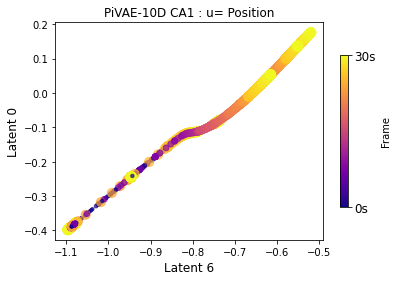

<Figure size 432x288 with 0 Axes>

In [16]:
t = sorted_indices[-5:]
print(t)
for i in range(len(t)):
    for j in range(i+1, len(t)):
        l = [t[i],t[j]]
        plot_multi_latent_trajectory_pupil_vt(behavior_data_df, outputs, latent_indicies=l, 
                                      workflow_name=f"{brain_region}_{MODEL}_{LATENT_DIM}D", num_stims=15, show_traj=False, save_plot=False, save_dir=None, show_plot=True, variances=variances)


### CA1 5D

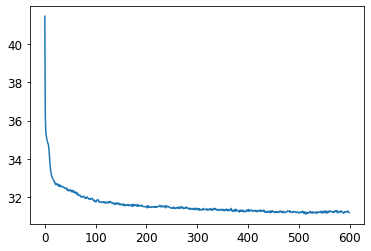

In [32]:
plt.plot(s_n.history['val_loss'][:]) # 10D

In [33]:
# model_chk_path = '../results/F_rat_10d_666_VAE.h5'
model_chk_path = f'../results/F_rat_{brain_region}_{LATENT_DIM}d_666_{MODEL}_{selected_behavior_vars[0]}.h5' ##999, 777
vae.load_weights(model_chk_path);

In [34]:
outputs = vae.predict_generator(custom_data_generator(x_all, u_all),
                                                steps = len(x_all));
# post_mean, post_log_var, z_sample,fire_rate, lam_mean, lam_log_var, z_mean, z_log_var
print(outputs[0].var(axis=0))  ## variance of each latent dimension

[0.08686154 0.05886384 1.9111111  1.4875449  1.6676803 ]


In [35]:
z_pred_all = [];
for ii in range(len(x_all)):
    z_pred_all.append(vae.predict([x_all[ii], u_all[ii]])[0][:,:]);
z_pred_all = np.array(z_pred_all);

In [36]:
variances = outputs[0].var(axis=0)
# Sort the columns by variance in descending order and get the indices
sorted_indices = np.argsort(variances)[::-1]

# Create a new object containing the columns of outputs[0] sorted by variance
sorted_outputs = outputs[0][:, sorted_indices]
print(variances,'\n')
print(sorted_outputs.var(axis=0),'\n',sorted_indices)

u_values = behavior_data_df['frame'].unique()

[0.08686154 0.05886384 1.9111111  1.4875449  1.6676803 ] 

[1.911116   1.6677015  1.4875492  0.08686276 0.05886412] 
 [2 4 3 0 1]


[2 4 3 0 1]
Latent 1 idx: 2
Latent 2 idx: 4


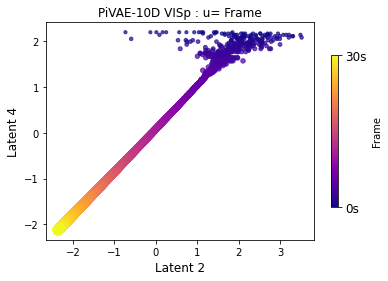

Latent 1 idx: 2
Latent 2 idx: 3


<Figure size 432x288 with 0 Axes>

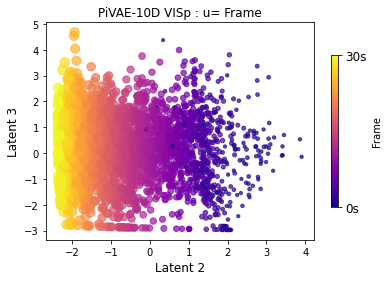

Latent 1 idx: 2
Latent 2 idx: 0


<Figure size 432x288 with 0 Axes>

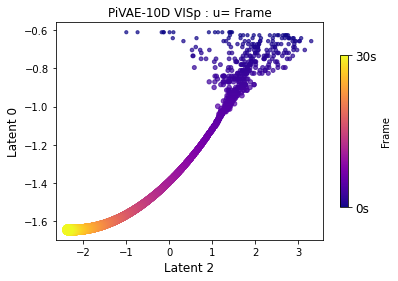

Latent 1 idx: 2
Latent 2 idx: 1


<Figure size 432x288 with 0 Axes>

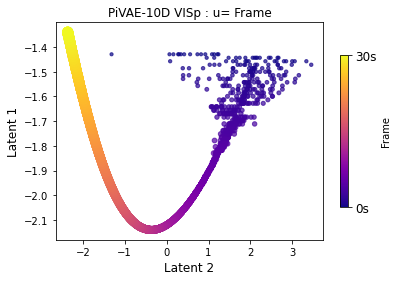

Latent 1 idx: 4
Latent 2 idx: 3


<Figure size 432x288 with 0 Axes>

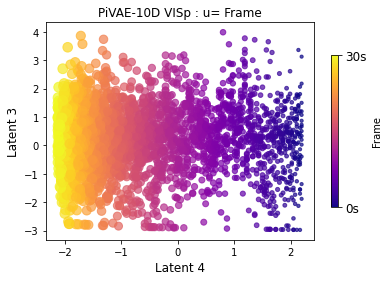

Latent 1 idx: 4
Latent 2 idx: 0


<Figure size 432x288 with 0 Axes>

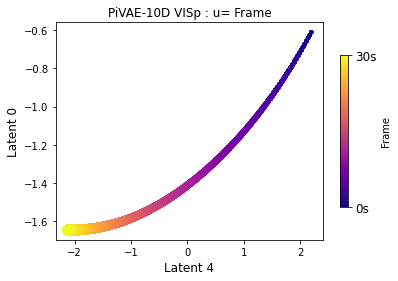

Latent 1 idx: 4
Latent 2 idx: 1


<Figure size 432x288 with 0 Axes>

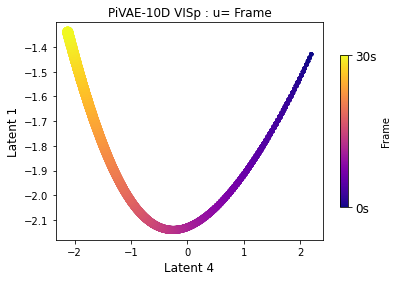

Latent 1 idx: 3
Latent 2 idx: 0


<Figure size 432x288 with 0 Axes>

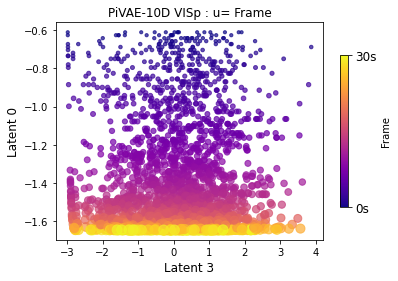

Latent 1 idx: 3
Latent 2 idx: 1


<Figure size 432x288 with 0 Axes>

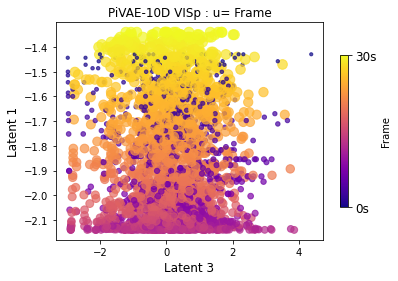

Latent 1 idx: 0
Latent 2 idx: 1


<Figure size 432x288 with 0 Axes>

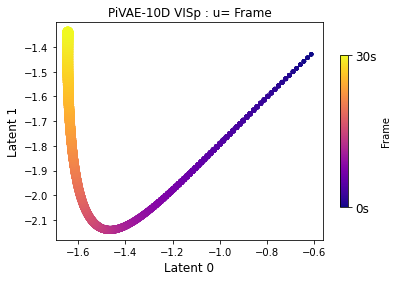

<Figure size 432x288 with 0 Axes>

In [29]:
t = sorted_indices[-5:]
print(t)
for i in range(len(t)):
    for j in range(i+1, len(t)):
        l = [t[i],t[j]]
        plot_multi_latent_trajectory_pupil_vt(behavior_data_df, outputs, latent_indicies=l, 
                                      workflow_name=f"{brain_region}_{MODEL}_{LATENT_DIM}D", num_stims=15, show_traj=False, save_plot=False, save_dir=None, show_plot=True, variances=variances)


[2 4 3 0 1]


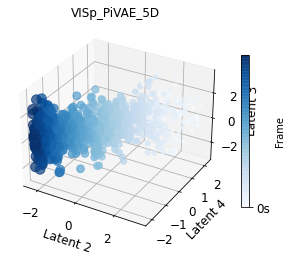

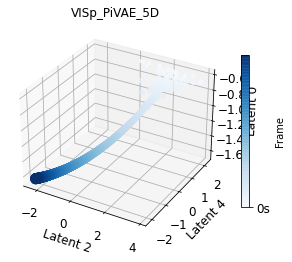

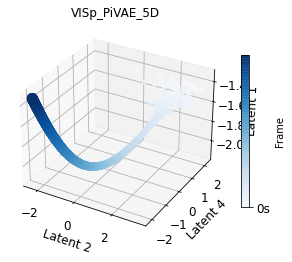

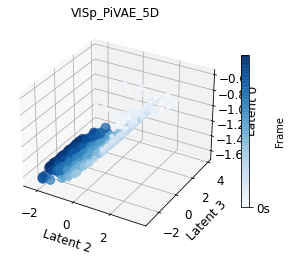

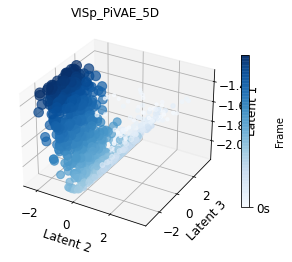

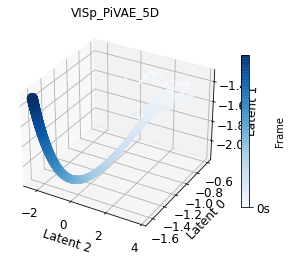

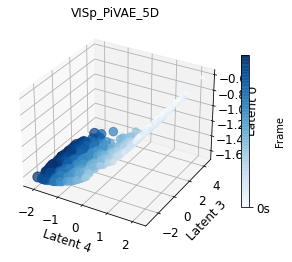

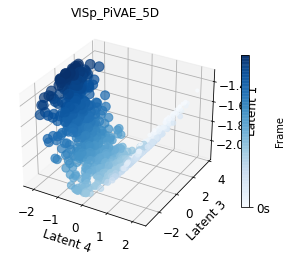

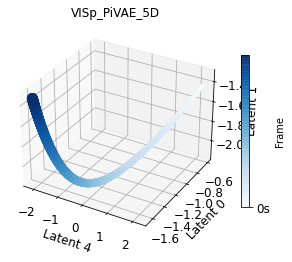

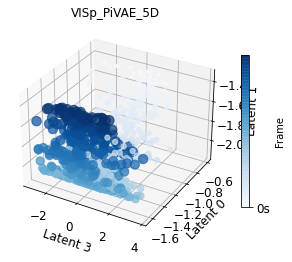

In [38]:
t = sorted_indices[-5:]
print(t)
for i in range(len(t)):
    for j in range(i+1, len(t)):
        for k in range(j+1, len(t)):
            l = [t[i],t[j], t[k]]
            plot_multi_latent_trajectory_pupil_v6(behavior_data_df, outputs, l, 
                                      workflow_name=f"{brain_region}_{MODEL}_{LATENT_DIM}D", num_stims=5, show_traj=False, save_plot=False, save_dir=None, show_plot=True, variances=variances)


### 3d test

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_multi_latent_trajectory_pupil_v6(behavior_df, outputs, latent_indices, workflow_name, num_stims=15, show_traj=True, save_plot=False, save_dir=None, show_plot=True, variances=None):
    """
    Plot 3D latent trajectories from several trials on a single plot.

    Args:
    - behavior_df (pandas.DataFrame): DataFrame containing behavior data including 'frame' and 'pupil_size'.
    - outputs (numpy.ndarray): Latent data.
    - latent_indices (list): Indices of the three latent dimensions to plot.
    - workflow_name (str): Name of the workflow.
    - num_stims (int): Number of randomly chosen trials to plot.
    - save_plot (bool, optional): Whether to save the plot. Default is False.
    - save_dir (str, optional): Directory to save the plot. Required if save_plot is True.
    - show_plot (bool, optional): Whether to show the plot. Default is True.
    - variances (list, optional): List of variances for each latent dimension.

    Returns:
    - A 3D scatter plot where pupil size has a color scale Greys in range [0,1]
    - Plots trajectories of points for each trial plotted, trajectory labeled by frame with color scale Plasma in range [0s, 30s]
    """
    # Set plot font size
    plt.rcParams.update({'font.size': 12})
    
    # Extract pupil size data and normalize
    pupil_sizes = behavior_df['pupil_size']
    pupil_sizes_normalized = (pupil_sizes - pupil_sizes.min()) / (pupil_sizes.max() - pupil_sizes.min())
    
    # Create a new 3D figure and axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    scatter_cmap = 'Blues'
    # Iterate over num_stims random stim_numbers
    stim_number_pool = np.random.choice(range(60), num_stims, replace=False)
    for stim_number in stim_number_pool:
        start_idx = 900 * stim_number
        end_idx = 900 * (stim_number + 1)
        data_slice = slice(start_idx, end_idx, 5)
        
        latent_1_data = outputs[0][data_slice, latent_indices[0]]
        latent_2_data = outputs[0][data_slice, latent_indices[1]]
        latent_3_data = outputs[0][data_slice, latent_indices[2]]
        
        # Filter data based on quantiles for each dimension
        filter_mask = np.ones(latent_1_data.shape, dtype=bool)
        for idx in latent_indices:
            lower_bound = np.quantile(outputs[0][data_slice, idx], 0.1)
            upper_bound = np.quantile(outputs[0][data_slice, idx], 0.9)
            filter_mask &= (outputs[0][data_slice, idx] >= lower_bound) & (outputs[0][data_slice, idx] <= upper_bound)
        filter_mask = np.ones(latent_1_data.shape, dtype=bool)
        latent_1_data_filtered = latent_1_data[filter_mask]
        latent_2_data_filtered = latent_2_data[filter_mask]
        latent_3_data_filtered = latent_3_data[filter_mask]
        # pupil_data_filtered = pupil_sizes_normalized[data_slice][filter_mask]
        pupil_data_filtered = behavior_df['frame'][data_slice][filter_mask] # <--- Change!

        # Define point sizes based on filtered pupil size
        point_sizes = 10 + 90 * pupil_data_filtered

        # Plot the scatter plot with varying point size and hue based on pupil size
        scatter = ax.scatter(latent_1_data_filtered, latent_2_data_filtered, latent_3_data_filtered, s=point_sizes, c=pupil_data_filtered, cmap=scatter_cmap, alpha=0.7)

    # Set labels with variance if provided
    ax.set_xlabel(f'Latent {latent_indices[0]}', fontsize=12)
    ax.set_ylabel(f'Latent {latent_indices[1]}', fontsize=12)
    ax.set_zlabel(f'Latent {latent_indices[2]}', fontsize=12)
    ax.set_title(workflow_name, fontsize=12)

    # Color bar for pupil size
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.7, pad=0.05)
    # cbar.set_label('Frame', fontsize=10)
    cbar.set_label('Frame', fontsize=10, labelpad=5)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels([f'0s', f'30s'])

    # Save or show the plot
    if save_plot:
        if save_dir:
            plt.savefig(f"{save_dir}/{workflow_name}.png")
        else:
            raise ValueError("Save directory not specified.")
    if show_plot:
        plt.show()

    plt.close(fig)

# Example usage:
# plot_multi_latent_trajectory_pupil_v6(behavior_df, outputs, [0, 1, 2], 'Example Workflow')


[4 8 2 7 6 1 5 0]


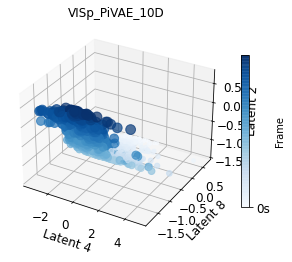

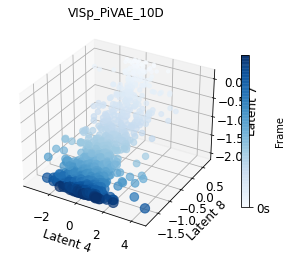

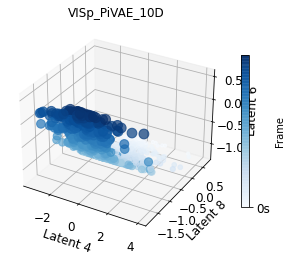

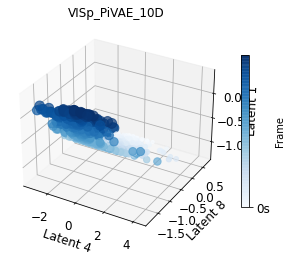

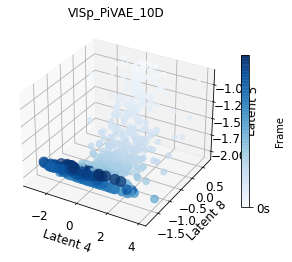

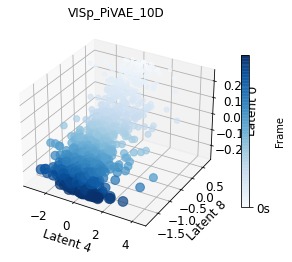

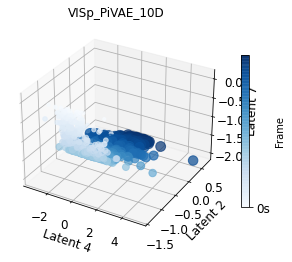

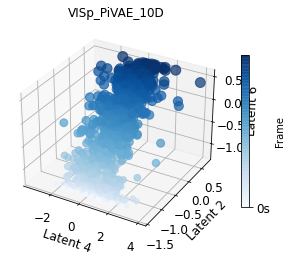

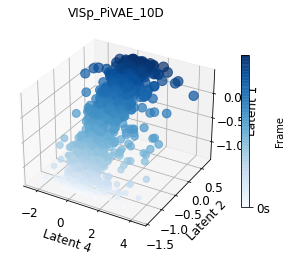

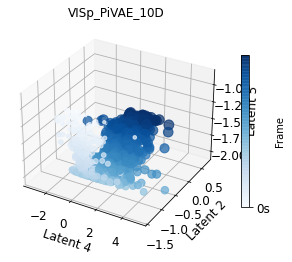

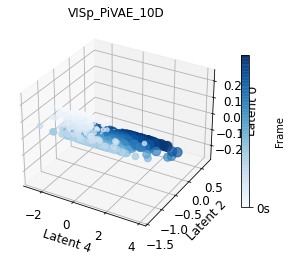

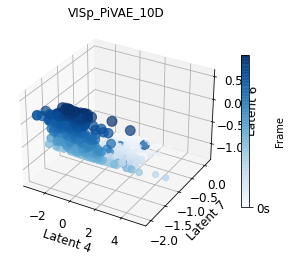

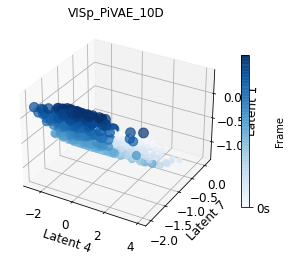

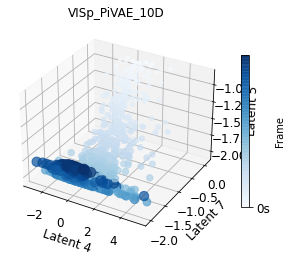

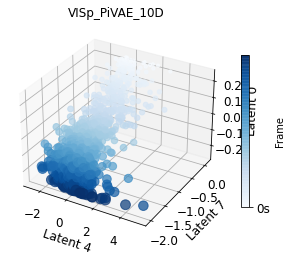

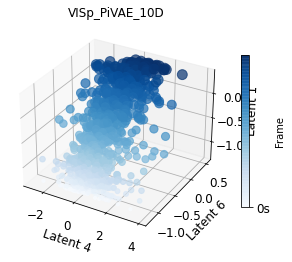

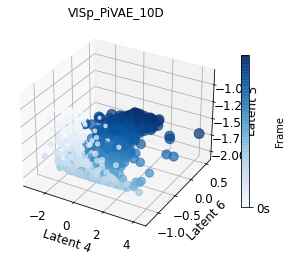

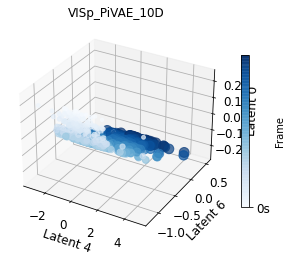

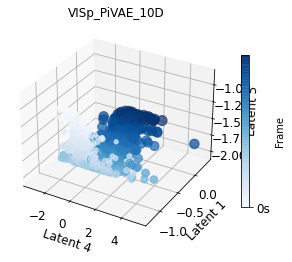

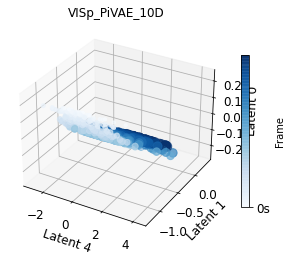

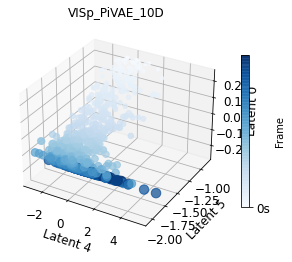

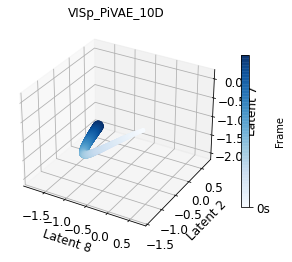

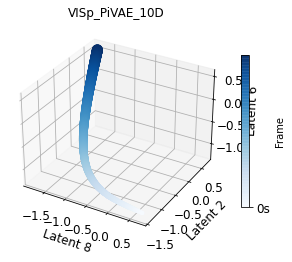

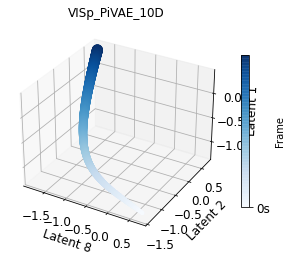

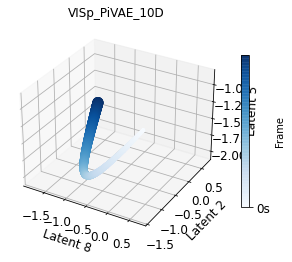

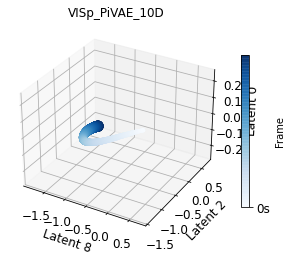

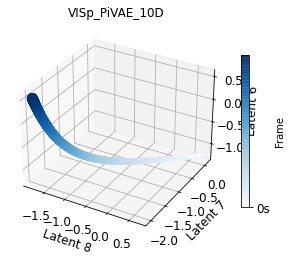

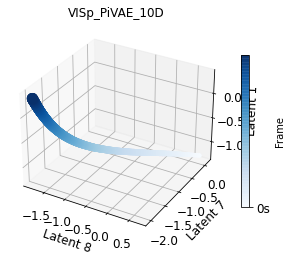

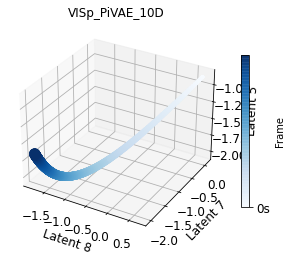

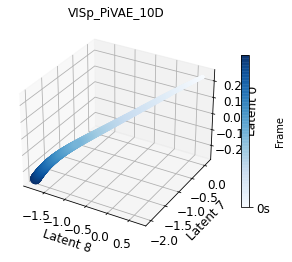

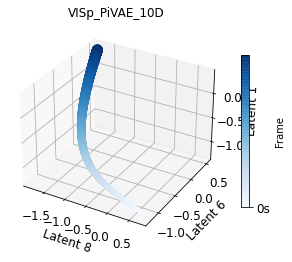

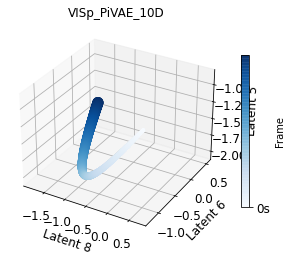

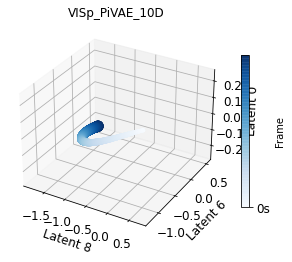

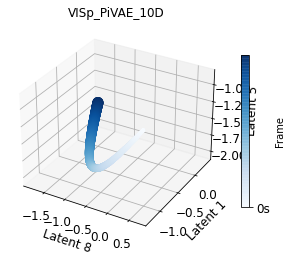

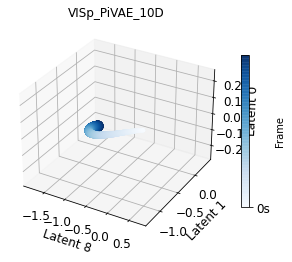

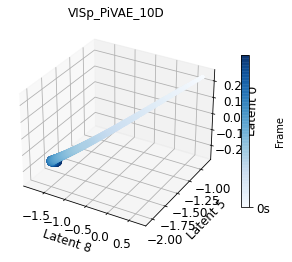

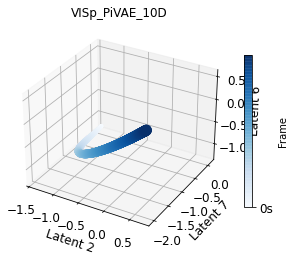

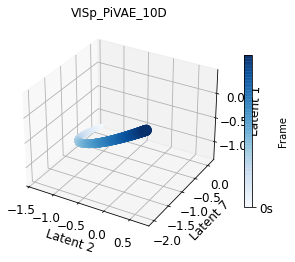

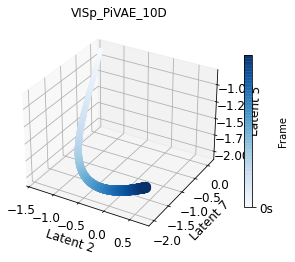

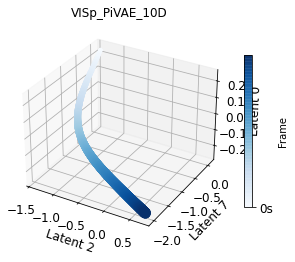

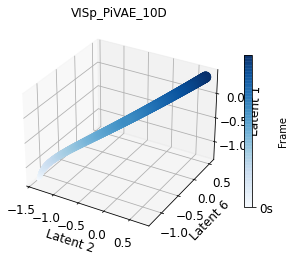

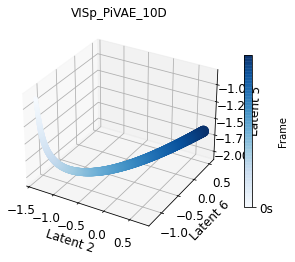

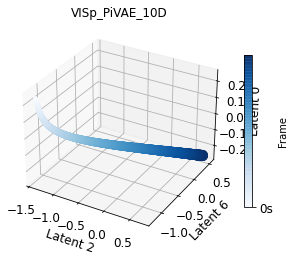

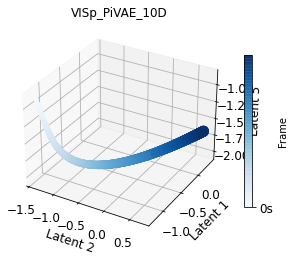

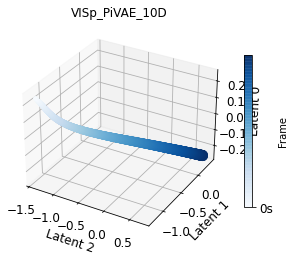

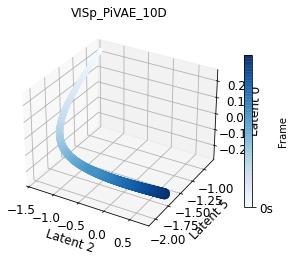

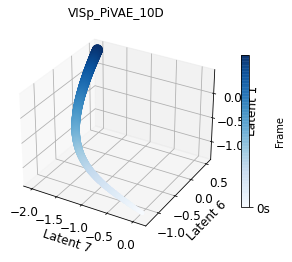

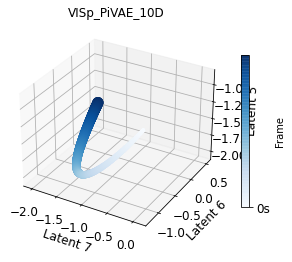

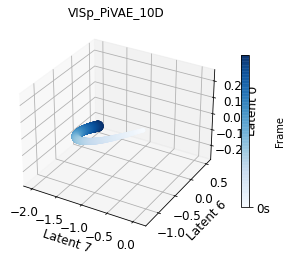

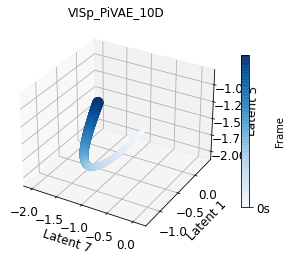

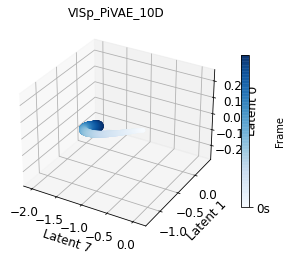

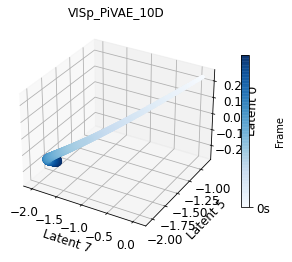

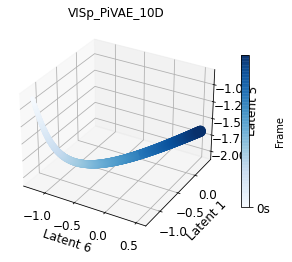

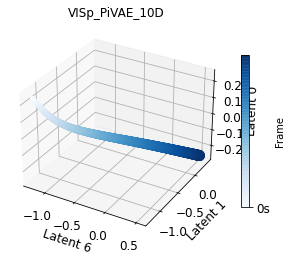

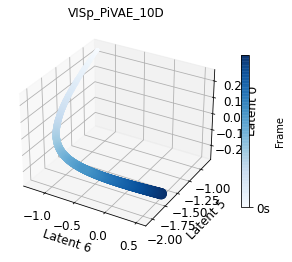

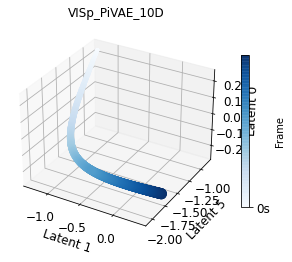

In [22]:
t = sorted_indices[-8:]
print(t)
for i in range(len(t)):
    for j in range(i+1, len(t)):
        for k in range(j+1, len(t)):
            l = [t[i],t[j], t[k]]
            plot_multi_latent_trajectory_pupil_v6(behavior_data_df, outputs, l, 
                                      workflow_name=f"{brain_region}_{MODEL}_{LATENT_DIM}D", num_stims=5, show_traj=False, save_plot=False, save_dir=None, show_plot=True, variances=variances)


### Downsample

In [39]:
def downsample(frames_per_window, x_all, u_all):
    # Check if frames_per_window is an odd number and divisor of the total frames
    total_frames = x_all[0].shape[0]
    if total_frames % frames_per_window != 0 or frames_per_window % 2 == 0:
        raise ValueError("Frames per window must be an odd number and a divisor of the total number of frames.")

    # Calculate the index of the middle frame in each window
    middle_index = frames_per_window // 2

    # Summing frames within each window and take the spike counts
    x_all_downsample = [np.sum(x_all[i].reshape(-1, frames_per_window, x_all[i].shape[-1]), axis=1) for i in range(len(x_all))]

    # Ensure the new shape is as expected
    print("New shape for each element:", x_all_downsample[0].shape)

    # Selecting the middle frame index from each window
    u_all_downsample = [u_all[i][middle_index::frames_per_window] for i in range(len(u_all))]

    # Ensure the new shape is as expected
    print("New shape for each element in u:", u_all_downsample[0].shape)

    return np.array(x_all_downsample), np.array(u_all_downsample)

In [40]:
x_all_downsample, u_all_downsample = downsample(5, x_all, u_all)

New shape for each element: (180, 249)
New shape for each element in u: (180, 1)


In [41]:
x_all_downsample.shape

(60, 180, 249)

## Modeling

In [45]:
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import KFold

def build_vae(dim_x, dim_u, latent_dim=10, gen_nodes=60, n_blk=2, mdl='poisson', disc=False, learning_rate=5e-4):
    # Assuming vae_mdl is a function that returns a compiled VAE model
    return vae_mdl(dim_x=dim_x, dim_z=latent_dim, dim_u=dim_u, gen_nodes=gen_nodes, n_blk=n_blk, mdl=mdl, disc=disc, learning_rate=learning_rate)

def train_and_save_model(x_train, u_train, x_valid, u_valid, latent_dim, epochs, fold_number, random_seed):
    # Build the VAE model
    vae = build_vae(dim_x=x_train[0].shape[-1], dim_u=u_train[0].shape[-1], latent_dim=latent_dim)
    
    # Define the directory path for model checkpointing
    # directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_frames'
    directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_{brain_region}_{selected_behavior_vars[0]}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    model_chk_path = f'{directory}/model_fold_{fold_number}.h5'
    
    # Setup model checkpointing
    mcp = ModelCheckpoint(model_chk_path, monitor="val_loss", save_best_only=True, save_weights_only=True)
    
    # Fit the model using fit_generator
    s_n = vae.fit_generator(custom_data_generator(x_train, u_train),
                            steps_per_epoch=len(x_train), epochs=epochs, 
                            verbose=1,
                            validation_data=custom_data_generator(x_valid, u_valid),
                            validation_steps=len(x_valid), callbacks=[mcp])
    
    # Clear the session to free up memory and prevent slowdowns
    K.clear_session()

def perform_k_fold_cv(x_all, u_all, latent_dim, epochs, random_seed, n_splits=5):
    np.random.seed(random_seed);
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    fold = 0
    kfold_indices = kf.split(x_all) # save and return for tuning curve use
    
    for train_index, test_index in kfold_indices:
        x_train, x_valid = x_all[train_index], x_all[test_index]
        u_train, u_valid = u_all[train_index], u_all[test_index]
        
        train_and_save_model(x_train, u_train, x_valid, u_valid, latent_dim, epochs, fold, random_seed)
        fold += 1

    return kfold_indices

### Initialize and Fit models

In [46]:
RANDOM_SEED = 666
n_folds = 10

kfold_indices = perform_k_fold_cv(x_all=x_all_downsample, u_all=u_all_downsample, latent_dim=10, epochs=100, random_seed=RANDOM_SEED, n_splits=n_folds)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 249)          0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  39420       input_7[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 249)          129017      encoder[1][2]                  

In [29]:
kf = KFold(n_splits=10, shuffle=True, random_state=666)
kfold_indices = kf.split(x_all_downsample)

In [12]:
# plt.plot(s_n.history['val_loss'][:])

## Decoding

### Prepare random samples

In [47]:
def generate_u_fake(x_test, frame_bins, nu_samples):
    """
    Generate a synthetic u dataset (u_fake_np) based on provided frame bins and test data.

    Parameters:
    - x_test: array-like, the test dataset where each element corresponds to a session.
    - frame_bins: array-like, unique frame indices to be used for generating u_fake.
    - nu_samples: int, number of unique frame indices to sample.

    Returns:
    - np.array, synthetic u dataset (u_fake_np).
    """
    np.random.seed(666)  # Seed for reproducibility
    u_fake_np = []
    
    # Ensure that the number of samples does not exceed the length of frame_bins
    nu_samples = min(nu_samples, len(frame_bins))
    
    for jj in range(nu_samples):
        tmp_all_np = []
        for ii in range(len(x_test)):
            nn = x_test[ii].shape[0]
            # Fill with the current frame bin value for all samples in this part of the dataset
            tmp_np = np.full((nn, 1), frame_bins[jj])
            tmp_all_np.append(tmp_np)
        u_fake_np.append(np.array(tmp_all_np))
    
    return np.array(u_fake_np)

### Decode and compute metric

In [48]:
from tqdm import tqdm
import scipy.special as ssp
from data_processing import *

def load_and_decode_vae(model, x_test, u_fake_np, model_path, n_sample=50, nu_samples=180):
    model.load_weights(model_path)
    pbar = tqdm(total=len(x_test) * len(u_fake_np), desc="Computing likelihoods for VAE")
    lik_all_np = []
    for jj in range(len(x_test)):
        # print(f"test {jj}")
        y_test_batch = x_test[jj]
        lik_batch = compute_marginal_lik_single_batch(model, y_test_batch, u_fake_np, n_sample, pbar)
        lik_all_np.append(lik_batch)
    pbar.close()
    decode_use_np = np.array([(lik.reshape(nu_samples, -1, order="F").argmax(axis=0)) for lik in lik_all_np])
    return decode_use_np

def load_and_decode_tc(x_train, x_test, frame_bins):
    tc = np.array(x_train).mean(axis=0) 
    lik_tc = [np.array([np.exp((x_test[jj]*np.log(np.clip(tc[ii],1e-7,1e6)) - tc[ii]).sum(axis=-1)) for ii in range(tc.shape[0])]) for jj in range(len(x_test))];
    lik_tc_use = np.concatenate([np.log(lik_tc[jj].mean(axis=0)) - ssp.loggamma(x_test[jj]+1).sum(axis=-1) for jj in range(len(lik_tc))]);
    
    decode_tc_use = np.array([lik_tc[jj].argmax(axis=0) for jj in range(len(lik_tc))]);
    # decode_tc_use_final = np.array([frame_bins[decode_tc_use[jj]] for jj in range(len(x_test))])
    return decode_tc_use
    
def compute_error(decoded_indices, u_test, frame_bins):
    errors = [np.abs(frame_bins[decoded] - u[:, 0]) for decoded, u in zip(decoded_indices, u_test)]
    return np.median(np.concatenate(errors))

def run_decoding_for_fold(model, x_train, u_train, x_test, u_test, u_fake, model_path, frame_bins, fold_number, error_file_path, n_sample=50, bin_len=181):
    # Decoding
    # print("start to move")
    decoded_indices_pivae = load_and_decode_vae(model, x_test, u_fake, model_path, n_sample)
    # print("moving")
    decoded_indices_tc = load_and_decode_tc(x_train, x_test, frame_bins)

    # Median Error
    error_pivae = compute_error(decoded_indices_pivae, u_test, frame_bins)
    error_tc = compute_error(decoded_indices_tc, u_test, frame_bins)

    # Append errors to the unified error file
    with open(error_file_path, 'a') as file:
        file.write(f"{fold_number}, {error_pivae:.3f}, {error_tc:.3f}\n")
    print(f"fold {fold_number}, Pi_vae error: {error_pivae:.3f}, TC error: {error_tc:.3f}\n")
    print(f"Appended errors for fold {fold_number} to {error_file_path}")

In [51]:
def main(x_all, u_all, kfold_indices, latent_dim, random_seed):
    directory = f'../results/rat_{latent_dim}d_{random_seed}_NP_5_{brain_region}_{selected_behavior_vars[0]}'
    frame_bins = np.unique(u_all)
    error_file_path = os.path.join(directory, 'model_errors.txt')

    # Ensure the directory exists and initialize the error file
    if not os.path.exists(directory):
        os.makedirs(directory)
    with open(error_file_path, 'w') as file:
        file.write("Fold, Pi-VAE Error, TC Error\n")

    model = build_vae(dim_x=x_all[0].shape[-1], dim_u=u_all[0].shape[-1], latent_dim=latent_dim)
    # Process each fold
    for fold_number, (train_index, test_index) in enumerate(kfold_indices):
        # if fold_number < 8:
        #     continue
        print(fold_number)
        x_train, x_test = x_all[train_index], x_all[test_index]
        u_train, u_test = u_all[train_index], u_all[test_index]
        # x_test = x_test[:1] 
        # u_test = u_test[:1]

        # Generate u_fake
        nu_samples = 180  # Define the number of unique frame indices to sample
        u_fake = generate_u_fake(x_test, frame_bins=frame_bins, nu_samples=nu_samples)

        # Decode and compute error for Pi-VAE & Tuning Curve
        model_path = os.path.join(directory, f'model_fold_{fold_number}.h5')
        run_decoding_for_fold(model, x_train, u_train, x_test, u_test, u_fake, model_path, frame_bins, fold_number, error_file_path)


In [52]:
kf = KFold(n_splits=10, shuffle=True, random_state=666)
kfold_indices = kf.split(x_all_downsample)

kfold_store = []
for fold_number, (train_index, test_index) in enumerate(kfold_indices):
    temp = (train_index, test_index)
    kfold_store.append(temp)
    # print(kfold_store[fold_number])

In [35]:
u_all_downsample[0].shape[-1]

1

In [ ]:
main(x_all=x_all_downsample, u_all=u_all_downsample, kfold_indices=kfold_store, latent_dim=10, random_seed=RANDOM_SEED)

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 249)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  39420       input_1[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 249)          129017      encoder[1][2]                  

Computing likelihoods for VAE: 100%|██████████| 1080/1080 [02:16<00:00,  7.91it/s]


fold 0, Pi_vae error: 0.295, TC error: 0.295

Appended errors for fold 0 to ../results/rat_10d_666_NP_5_CA1_frame/model_errors.txt
1


Computing likelihoods for VAE: 100%|██████████| 1080/1080 [03:08<00:00,  5.73it/s]


fold 1, Pi_vae error: 0.278, TC error: 0.320

Appended errors for fold 1 to ../results/rat_10d_666_NP_5_CA1_frame/model_errors.txt
2


Computing likelihoods for VAE: 100%|██████████| 1080/1080 [04:23<00:00,  4.09it/s]


fold 2, Pi_vae error: 0.295, TC error: 0.314

Appended errors for fold 2 to ../results/rat_10d_666_NP_5_CA1_frame/model_errors.txt
3


Computing likelihoods for VAE:  14%|█▍        | 156/1080 [00:46<04:48,  3.21it/s]

In [19]:
for fold_number, (train_index, test_index) in enumerate(kfold_store):
    print(fold_number, train_index, test_index)

0 [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 22 24 26 27
 28 29 30 31 33 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59] [ 8 21 23 25 32 34]
1 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24
 25 26 27 28 30 31 32 33 34 36 37 38 39 40 41 42 43 44 45 46 47 49 50 51
 52 53 55 56 57 59] [22 29 35 48 54 58]
2 [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 42 43 44 45 46 47 48 49 50 51
 52 53 54 56 57 58] [ 3 17 19 41 55 59]
3 [ 2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 47 48 50 52 53
 54 55 56 57 58 59] [ 0  1  7 46 49 51]
4 [ 0  1  2  3  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 39 40 41 42 44 45 46 47 48 49 50 51 52
 53 54 55 56 58 59] [ 4 10 37 38 43 57]
5 [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 